## <span style="color:#008000"> Imports </span>

#### <span style="color:orange"> Installing LazyPredict : </span>
- Lazypredict
    - 머신러닝 자동화 관련 파이썬 오픈소스 프로젝트
    - 코드 한 줄로 여러 ML 모델 학습, 추론 결과 확인 가능
    - 여러 모델의 성능 지표 비교 가능
    - 파라미터를 조정할 수 없다는 한계
    - 내부 소스코드에 StandardScaler가 적용되어 있음
        - StandardScaler : 표준화, 모든 피처를 평균이 0, 분산이 1인 정규분포를 갖도록 만들어 줌
    - 모델 성능 향상을 위해 Feature Engineering이나 파라미터를 튜닝하는 방식을 추가해야 함
        - Feature Engineering : 주어진 데이터를 예측 모델의 문제를 잘 표현할 수 있는 features로 변형시키는 과정, 모델 성능에 미치는 영향이 큼

In [63]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output() # 기존에 그렸던 객체 지우기

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore') # 경고 메시지 무시하고 숨기기

## <span style="color:#008000"> Data Loading and Preparation </span>

In [66]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

# imputation - strategy는 결측값을 채우기 위해 사용됨
# median 외에도 mean, most_frequent, constant가 기본적으로 제공됨

## <span style="color:orange"> Column Descriptions </span>
- <span style="background-color:#f6f8fa"> PassengerId </span>
    - 승객의 고유 ID
    - gggg_pp 형식
    - gggg : 승객이 함께 여행하는 그룹, pp : 그룹 내 승객 번호
- <span style="background-color:#f6f8fa"> HomePlanet </span>
    - 승객이 거주하는 행성
- <span style="background-color:#f6f8fa"> CryoSleep </span>
    - 승객의 냉동 수면 여부
- <span style="background-color:#f6f8fa"> Cabin </span>
    - 승객이 머물고 있는 객실 번호
    - deck/num/side 형식
- <span style="background-color:#f6f8fa"> Destination </span>
    - 승객의 목적지
- <span style="background-color:#f6f8fa"> Age </span>
    - 승객의 나이
- <span style="background-color:#f6f8fa"> VIP </span>
    - 항해 중 승객이 VIP 서비스에 대한 비용 지불 여부
- <span style="background-color:#f6f8fa"> RoomService </span>
    - 편의 시설에 대한 청구 금액
- <span style="background-color:#f6f8fa"> Name </span>
    - 승객의 이름
- <span style="background-color:#f6f8fa"> Transported </span>
    - 승객이 다른 차원으로 운송되었는지 여부

### <span style="color:orange"> Exploring Train Data : </span>

#### <span style="color:orange"> Quick view of Train Data : </span>

In [67]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [68]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


#### <span style="color:orange"> Column Wise missing values : </span>

In [69]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False)) # 내림차순


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


#### <span style="color:orange"> Basic statistics of training data : </span>

count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum

In [70]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


### <span style="color:orange"> Exploring Test Data </span>

#### <span style="color:orange"> Quick view of Test Data </span>

In [71]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [72]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values in test data: 1117


#### <span style="color:orange"> Column Wise missing values </span>

In [73]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


#### <span style="color:orange"> Basic statistics of training data : </span>

count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum

In [74]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


### <span style="color:orange"> Submission File </span>

#### <span style="color:orange"> Quick view of Submission File </span>

In [75]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## <span style="color:green"> EDA </span>

### <span style="color:orange"> Overview of Data </span>

In [76]:
train.drop(["PassengerId"], axis = 1, inplace = True)
test.drop(["PassengerId"], axis = 1, inplace = True)
# pd.drop() : 데이터 삭제
# axis = 0 : 행 삭제, axis = 1 : 열 삭제
# inplace = True : 지우려고 하는 column까지 삭제
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [77]:
# df.iloc[] : 값 추출
# T(Transformation) : 행과 열을 바꿔주는 함수
# std : 표준편차
# style.background_gradient : 수치의 크기를 색상 온도로 보는 함수
# cmap : colormap
# bar : 막대 옵션 변경

#train.iloc[:, :-1].describe().T.sort_values(by='std', ascending = False)\
#                    .style.background_gradient(cmap='GnBu')\
#                    .bar(subset=["max"], color='#BB0000')\
#                    .bar(subset=["mean",], color='green')

### <span style="color:orange"> Null Value Distribution </span>

#### <span style="color:orange"> Column wise Null Value Distribution </span>

In [78]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0, ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0, ascending = False)[:-1]

fig = make_subplots(rows = 1, cols = 2, column_titles = ["train Data", "Test Data"], x_title = "Missing Values")

fig.add_trace(go.Bar(x = train_null[0],
                     y = train_null.index,
                     orientation = "h",
                     marker = dict(color = [n for n in range(12)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = "coloraxis")),
                 1, 1)
fig.add_trace(go.Bar(x = test_null[0],
                     y = test_null.index,
                     orientation = "h",
                     marker = dict(color = [n for n in range(12)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = "coloraxis")),
                 1, 2)

fig.update_layout(showlegend = False, title_text = "Column wise Null Value Distribution", title_x = 0.5)

#### <span style="color:orange"> Row wise Null Value Distribution </span>

In [79]:
missing_train_row = train.isna().sum(axis = 1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis = 1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100

fig = make_subplots(rows = 1,
                    cols = 2,
                    column_titles = ["Train Data", "Test Data"],
                    x_title = "Missing Values",)

fig.add_trace(go.Bar(x = missing_train_row["no"],
                     y = missing_train_row["count"],
                     marker = dict(color = [n for n in range(4)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 3,
                                   coloraxis = "coloraxis")),
                 1, 1)
fig.add_trace(go.Bar(x = missing_test_row["no"],
                     y = missing_test_row["count"],
                     marker = dict(color = [n for n in range(4)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 3,
                                   coloraxis = "coloraxis")),
                 1, 2)
fig.update_layout(showlegend = False, title_text = "Row wise Null Value Distribution", title_x = 0.5)

#### <span style="color:orange"> Dealing with missing value(reference) </span>

### <span style="color:orange"> Continuos and Categorical Data Distribution </span>

In [80]:
# pd.concat : pandas의 DataFrame 합치는 방법
# axis = 0 : 위, 아래로 합치기
# axis = 1 : 왼쪽, 오른쪽으로 합치기
df = pd.concat([train[FEATURES], test[FEATURES]], axis = 0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]
# nunique() : 데이터에 고유값들의 수를 출력해주는 함수

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels = ['Categorical', 'Continuos', "Text"]
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

# go.Figure() : 기본 그래프 생성
# go.Pie() : Pie Chart 그리기
# pull : 조각 별 거리
fig = go.Figure(data = [go.Pie(labels = labels,
                               values = values,
                               pull = [0.1, 0, 0],
                               marker = dict(colors = colors,
                                             line = dict(color = '#000000', width = 2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


### <span style="color:orange"> Feature Distribution of Continous Features </span>

#### <span style="color:orange"> Distribution of Age </span>

In [81]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
# histogram : 순서형 자료와 수치형 자료를 도수분포표를 이용해 그래프로 나타냄
fig = px.histogram(data_frame = ageDf,
                   x = "Age",
                   color = "type",
                   color_discrete_sequence = ['#58D68D', '#DE3163'], # 불연속 그래프의 색 지정
                   marginal = "box",
                   nbins = 100,
                   template = "plotly_white")
# fig.update_layout : 그래프 생성 후 layout 정보 업데이트
fig.update_layout(title = "Distribution of Age", title_x = 0.5)
fig.show()

### <span style="color:orange"> Feature Distribution of Categorical Features </span>

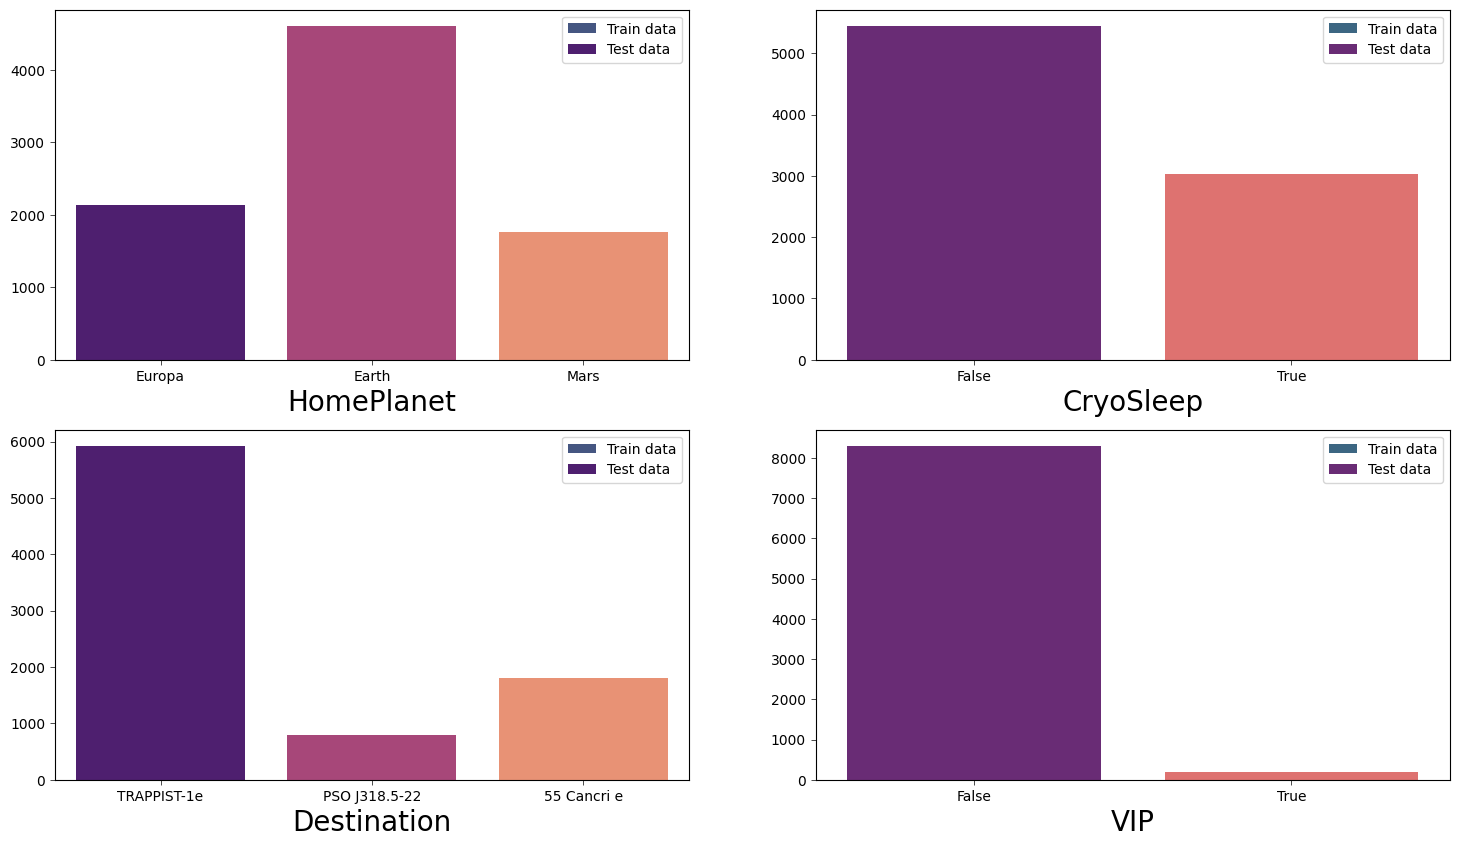

In [86]:
if len(cat_features) == 0:
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize = (18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col], ax = axes[r,c], x = train[col], palette = "viridis", label = 'Train data')
            sns.countplot(test[col], ax = axes[r,c], x = train[col], palette = "magma", label = 'Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize = 20)
            axes[r,c].tick_params(labelsize = 10, width = 0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

### <span style="color:orange"> Target Distribution </span>

In [87]:
# value_counts : 열의 각 값에 대한 모든 발생 횟수 반환
# reset_index : 인덱스 재배열
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame = target_df,
             x = TARGET,
             y = 'count')
fig.update_traces(marker_color = ['#58D68D', '#DE3163'],
                  marker_line_color = 'rgb(0, 0, 0)',
                  marker_line_width = 2)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1] *100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


### <span style="color:orange"> Correlation matrix </span>

In [88]:
# imshow : array의 값을 색으로 환산해 이미지 형태로 보여줌
fig = px.imshow(train.corr(), text_auto = True, aspect = "auto", color_continuous_scale = "viridis")
fig.show()

## <span style="color:green"> Data Pre-Processing </span>

#### <span style="color:orange"> Imputing Missing Values </span>

In [89]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
imputer = SimpleImputer(strategy = STRATEGY)
imputer.fit(train[imputer_cols])
# imputer.transform : 결측치 대치
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace = True)
test["HomePlanet"].fillna('Z', inplace = True)

#### <span style="color:orange"> Encoding Categorical Features </span>

In [90]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        # LabelEncoder().fit_transform : 데이터 인코딩
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

train, test = label_encoder(train, test, label_cols)

In [91]:
train.drop(["Name", "Cabin"], axis = 1, inplace = True)
test.drop(["Name", "Cabin"], axis = 1, inplace = True)
X = train.drop(TARGET, axis = 1)
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12, test_size = 0.33)
# train_test_split : 데이터 분할

## <span style="color:green"> Modeling </span>

#### <span style="color:orange"> 27 Different Classifiers (LAZY PREDICT): </span>

In [92]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=False, random_state=12, classifiers='all')

models, predictions = clf.fit(X_train, X_test, y_train, y_test)
clear_output()

#### <span style="color:orange"> TOP 15 Models </span>

In [93]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.57
XGBClassifier,0.78,0.78,0.78,0.78,0.69
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.33
RandomForestClassifier,0.77,0.77,0.77,0.77,1.01
NuSVC,0.77,0.77,0.77,0.77,2.05
LogisticRegression,0.77,0.77,0.77,0.77,0.17
SVC,0.77,0.77,0.77,0.77,1.65
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.83
LinearSVC,0.76,0.76,0.76,0.76,0.51


#### <span style="color:orange"> Visualizing Results </span>

In [94]:
line = px.line(data_frame=models, y=["Accuracy"], markers=True)
line.update_xaxes(title="Model", rangeslider_visible=False) # x축에 대한 편집
line.update_yaxes(title="Accuracy") # y축에 대한 편집
line.update_traces(line_color="red") #  이미 생성된 trace의 type, 색, 스타일, 템플릿 등의 추가 편집
line.update_layout(showlegend=True, title={'text':'Accuracy vs Model', 'y':0.94, 'x':0.5, 'xanchor':'center', 'yanchor':'top'}) # 그래프의 외적인 요소 업데이트

In [95]:
line = px.line(data_frame=models, y=["ROC AUC", "F1 Score"], markers=True)
line.update_xaxes(title="Model", rangeslider_visible=False) # 범위 슬라이더 추가
line.update_yaxes(title="ROC AUC SCORE")
line.update_layout(showlegend=True, title={'text':'ROC AUC and F1 SCore vs Model', 'y':0.94, 'x':0.5, 'xanchor':'center', 'yanchor':'top'})

line.show()

In [96]:
line = px.line(data_frame=models, y=["Time Taken"], markers=True)
line.update_xaxes(title="Model", rangeslider_visible=False)
line.update_yaxes(title="Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend=True, title={'text':'TIME TAKEN vs Model', 'y':0.94, 'x':0.5, 'xanchor':'center', 'yanchor':'top'})
line.show()

#### <span style="color:orange"> LGBM Classifier(5 FOLDS): </span>

In [97]:
lgb_params={'objective':'binary', 'n_estimators':50, 'learning_rate':0.08}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])): # enumerate로 tuple 만들어주기
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES, data=model.feature_importances_, columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES])
    lgb_predictions += test_preds/FOLDS
    
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.81%, Run Time: 0.35s

========== Fold=2 ==========
Fold=2, Accuracy score: 0.78%, Run Time: 0.34s

========== Fold=3 ==========
Fold=3, Accuracy score: 0.79%, Run Time: 0.35s

========== Fold=4 ==========
Fold=4, Accuracy score: 0.79%, Run Time: 0.36s

========== Fold=5 ==========
Fold=5, Accuracy score: 0.81%, Run Time: 0.34s

Mean Accuracy : 0.7958136330880743


#### <span style="color:orange"> Feature Importance </span>

In [101]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_34/4252013773.py", line 2, in <module>
    lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 920, in __call__
    return plot_backend.plot(data, x=x, y=y, kind=kind, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1886, in _get_plot_backend
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1817, in _load_backend
    # Fall back to unregistered, module name approach.
ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

During handling of the above exception, another exception occurred:

Traceback (most recent c

## <span style="color:green"> Submission </span>

#### <span style="color:orange"> LGBM Classifier Submission: </span>

In [102]:
submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv", index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
